<a href="https://colab.research.google.com/github/mgarciasanes/metodosdeagrupamiento_nosupervisado/blob/master/05_probabilidad_em.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> Aplicación de los Métodos de Agrupamiento</h1></center>
<center><h1> Aprendizaje No Supervisado</h1></center>
<center><h1> Agrupamiento basado en probabilidades : EM</h1></center>
<br>

### - Alexandro López González
### - Leonardo Pacheco Garduño
### - Manuel Garcia Sanes
<br>
<br>

En este notebook, realizaremos los siguiente:

- Aplicación del algoritmo EM  a los dos datasets seleccionados. 

- Evaluación de los resultados utilizando métricas intrínsecas o extrínsecas según sea el caso

- Análisis del resultado
<br>
<br>


---
## 1. Cargamos las librerias necesarias   

In [0]:

import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D


from scipy.stats import multivariate_normal



## 2. Cargamos el dataset con agrupamiento conocido   

####Nombre:

SEEDS



####Abstract: <br>

Measurements of geometrical properties of kernels belonging to three different varieties of wheat. A soft X-ray technique and GRAINS package were used to construct all seven, real-valued attributes.
	
####Atributos (Reales): <br>
1. area A,
2. perimeter P,
3. compactness C = 4*pi*A/P^2,
4. length of kernel,
5. width of kernel,
6. asymmetry coefficient
7. length of kernel groove.
All of these parameters were real-valued continuous.

####Instancias: 
210

####URL: 
https://archive.ics.uci.edu/ml/datasets/seeds# <br>


El dataset cargado tiene 210 instancias, 7 atributos y 3 clusters.


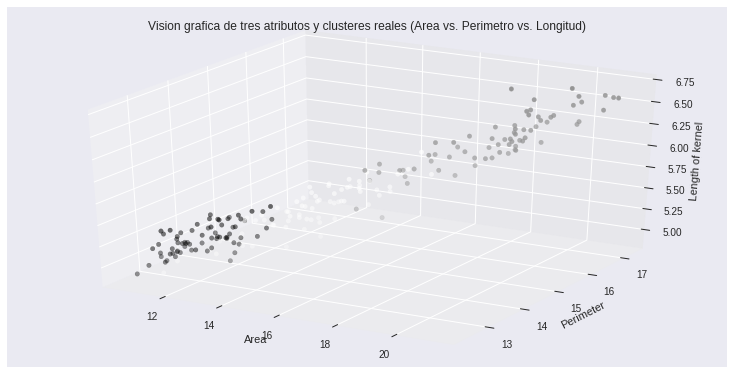

In [3]:
np.random.seed(31) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

#Cargamos los datos
data_file_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt'

#Mezclamos y separamos la columa clase  
D = np.array(pd.read_csv(data_file_url,delimiter='\s+', header=None))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:-1]
Dy = D[:,-1]

#Mostrar graficamente los datos (solo 3 atributos)
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:, 0], Dx[:, 1], Dx[:, 3], c=Dy)
ax.set_xlabel("Area")
ax.set_ylabel("Perimeter")
ax.set_zlabel("Length of kernel")
ax.set_title("Vision grafica de tres atributos y clusteres reales (Area vs. Perimetro vs. Longitud)")


print('El dataset cargado tiene',Dx.shape[0],'instancias,', Dx.shape[1], 'atributos y' ,len(np.unique(Dy)) , 'clusters.')

## 2.1 Aplicamos el Algoritmo seleccinado: EM


El algoritmo EM tiene un único parámetro: el número de clústeres (K). 

Una vez fijado este valor, el primer paso consiste en inicializar el modelo.

- Se eligen unos centros iniciales de manera aleatoria
- Unas matrices de covarianzas fijas 
- Pesos iniciales para las diferentes componentes.  (Sin más información, lo más normal sería asignar a todas las componentes el mismo peso.)

Los centros iniciales elegidos aleatoriamente son:
[[14.38378262 12.89038945  0.88814732  6.4002207   2.84254336  4.38685698
   5.24556055]
 [15.99933102 15.45446092  0.86466949  4.97330884  3.53340132  6.98987105
   5.82349287]
 [15.98229248 12.87239478  0.8829372   6.57020984  3.76779891  0.92560888
   5.94185277]
 [13.95432205 16.73655476  0.86666316  6.35681564  3.97808352  2.71056639
   5.62361248]]
Hemos querido incluir la representacion grafica de los datos. Aunque los datos tienen 7 atributos, representamos solo 3 de ellos:



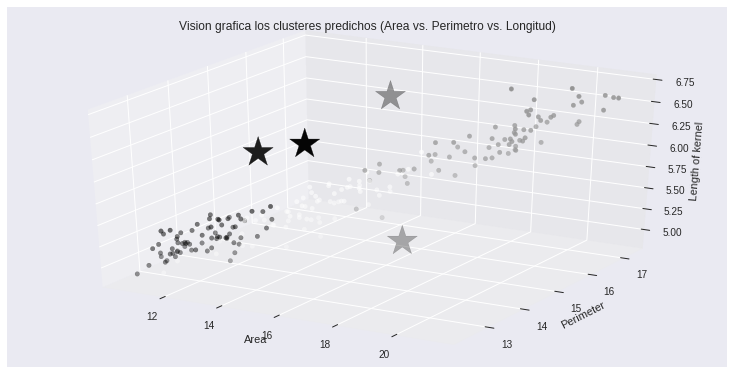

In [5]:
######################## INICIALIZACION ########################
# Elegimos un número de clústeres a buscar
K = 4


# Asignar unas matrices de covarianzas iniciales
sigmas = []
for k in np.arange(K):
    sigmas.append( np.diag( 0.1 * np.ones( Dx.shape[1] ) ) )

x, y = np.mgrid[(np.min(Dx[:,0])-0.1):(np.max(Dx[:,0])+0.1):.01, 
                (np.min(Dx[:,1])-0.1):(np.max(Dx[:,1])+0.1):.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

# Inicialmente consideramos que todas las componentes tienen la misma probabilidad
PIs = np.ones(K)/K




def random_sample_float(n, mi, ma):
    return (ma - mi) * np.random.random_sample(n) + mi

# Elegir unos centros (uno para cada componente) de manera aleatoria
cDx = np.zeros(K*Dx.shape[1])
cDx.shape = (K,Dx.shape[1])

for d in np.arange(Dx.shape[1]):
    cDx[:,d] = random_sample_float(K, np.min(Dx[:,d]), np.max(Dx[:,d]))

print('Los centros iniciales elegidos aleatoriamente son:')
print(cDx)


# Ver asignaciones finales
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:, 0], Dx[:, 1], Dx[:, 3], c=Dy)
ax.scatter(cDx[:, 0], cDx[:, 1], cDx[:, 3], marker='*', c='#050505', s=1000)
ax.set_xlabel("Area")
ax.set_ylabel("Perimeter")
ax.set_zlabel("Length of kernel")
ax.set_title("Vision grafica los centroides iniciales (Area vs. Perimetro vs. Longitud)")
print("Hemos querido incluir la representacion grafica de los datos. Aunque los datos tienen 7 atributos, representamos solo 3 de ellos:")
print()




Una vez inicializado, el algoritmo EM ejecuta un bucle donde se repiten los pasos E y M hasta que se alcanza la convergencia. 

En el paso E se (re)calcula la probabilidad de que cada ejemplo pertenezca a cada una de las componentes (los valores $z_{ik}$). 

En el paso M se (re)calculan los parámetros del modelo: los centros de las distribuciones normales (uno por componente, $\mu_k$), las matrices de covarianzas de las normales (una por componente, $\Sigma_k$) y los coeficientes de importancia de las diferentes componentes ($\{\pi_k\}_{k=1}^K$, con $\sum_k \pi_k=1$).

El algoritmo alcanza la convergencia cuando los parámetros no cambian entre dos iteraciones consecutivas.


In [0]:
# Preparamos el vector donde guardamos la asignación probabilística 
# de cada elemento a un clúster (z_ik)
Dy_probs = np.zeros((Dx.shape[0], K))

# Flag de convergencia
iterando = True
# Dibujar los plots intermedios?
dibujar = False
# Si dibujas, sólo uno de cada 'frec_dibujo'
frec_dibujo = 10

it = 0

while iterando:

    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    
    # PASO E:
    # Calcular la asignacion a las componentes (z_ik)
    for k in np.arange(K):
        Dy_probs[:,k] = PIs[k] * multivariate_normal.pdf(Dx, mean=cDx[k,:], cov=sigmas[k])
    Dy_probs = Dy_probs/np.sum(Dy_probs,axis=1)[:,None]
    
    # PASO M:
    # - a: Calcular los nuevos centros de las K componentes
    for k in range(K):
        cDx[k,:] = np.sum(Dy_probs[:,k,None]*Dx,axis=0)/np.sum(Dy_probs[:,k])

    # - b: Calcular la matriz de covarianza (sigma) de las K componentes
    for k in range(K):
        sigmas[k] = np.sum([Dy_probs[i,k]* np.dot(Dx[i,:,None]-cDx[k,:,None],
                                                  (Dx[i,:,None]-cDx[k,:,None]).transpose())
                            for i in np.arange(Dx.shape[0])], axis=0) / np.sum(Dy_probs[:,k])

    # - c: Calcular los coeficientes de importancia de las diferentes componentes
    PIs = np.sum(Dy_probs,axis=0)/Dx.shape[0]

    if dibujar and (it % frec_dibujo) == 0:
        # Dibujar el plot con el resultado actual
        fig, ax = plt.subplots(figsize=(10,5))
        for k in np.arange(K):
            rv = multivariate_normal(mean=cDx[k,:], cov=sigmas[k])
            ax.contour(x, y, rv.pdf(pos), levels=10, linewidths=1,colors='k',alpha=0.1)
            ax.contourf(x, y, rv.pdf(pos), levels=10, cmap="RdBu_r",alpha=0.1)
        ax.scatter(Dx[:,0],Dx[:,1])
        ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='g')

    it += 1
    if np.allclose(cDx, cDx_ant):
        break
            


El resultado final del algoritmo es una matriz de probabilidades que asigna cada elemento a un clúster (componente) con cierta probabilidad. Si quisiésemos obtener una asignación determinista de cada caso a un único clúster, tomaríamos la componente que mayor probabilidad asigna a cada caso como su clúster:


Hemos querido incluir la representacion grafica de los datos. Aunque los datos tienen 7 atributos, representamos solo 3 de ellos:



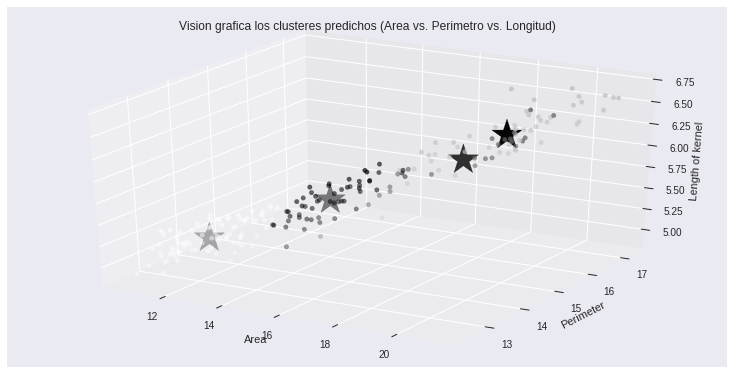

In [9]:
Dyp = np.argmax(Dy_probs,axis=1)


# Ver asignaciones finales
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:, 0], Dx[:, 1], Dx[:, 3], c=Dyp)
ax.scatter(cDx[:, 0], cDx[:, 1], cDx[:, 3], marker='*', c='#050505', s=1000)
ax.set_xlabel("Area")
ax.set_ylabel("Perimeter")
ax.set_zlabel("Length of kernel")
ax.set_title("Vision grafica los clusteres predichos (Area vs. Perimetro vs. Longitud)")
print("Hemos querido incluir la representacion grafica de los datos. Aunque los datos tienen 7 atributos, representamos solo 3 de ellos:")
print()


## 2.2 Evaluacion Extriniseca del Algoritmo seleccinado: EM

- Matriz Confusion
- Informacion Mutua
- Valor de Error
- Pureza del Agrupamiento
- Precision
- Recall
- F1
- Entropia





In [10]:
def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real==cats[i],cat_pred==clusts[j])) for j in np.arange(clusts.size)] for i in np.arange(cats.size)])
    return(mat)

def medida_error(mat):
    assign = np.sum([np.max(mat[l,:]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))

def medida_precision(mat, l, k):
    return mat[l,k]/float(np.sum(mat[:,k]))

def medida_recall(mat, l, k):
    return mat[l,k]/float(np.sum(mat[l,:]))

def medida_pureza(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))
    return np.sum([ float(np.sum(mat[:,k]))/float(np.sum(mat))
                   * np.max(mat[:,k]/float(np.sum(mat[:,k]))) for k in np.arange(mat.shape[1])])

def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec+rec)==0:
        return 0
    else:
        return (2*prec*rec)/(prec+rec)

def medida_f1(mat):
    totales = np.sum(mat,1)/float(np.sum(mat))
    assign = np.sum([totales[l] * np.max([medida_f1_especifica(mat, l, k) 
                                          for k in np.arange(mat.shape[1])]) 
                     for l in np.arange(mat.shape[0])])
    return assign

def medida_entropia(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))
    relMat = mat/np.sum(mat,0)
    logRelMat = relMat.copy()
    logRelMat[logRelMat==0]=0.0001 # Evita el logaritmo de 0. Inofensivo pues luego desaparece al multiplicar por 0
    logRelMat = np.log(logRelMat)
    return -np.sum([totales[k] * np.sum([relMat[l,k]*logRelMat[l,k] 
                                         for l in np.arange(mat.shape[0])]) 
                    for k in np.arange(mat.shape[1])])

def medida_informacion_mutua(mat):
    relMat = mat/float(np.sum(mat))
    logRelMat = mat.copy()
    logRelMat = logRelMat/np.sum(mat,0,keepdims=True)
    logRelMat = logRelMat/np.sum(mat,1,keepdims=True)
    logRelMat[logRelMat==0]=0.000001 # Evita el logaritmo de 0. Inofensivo pues luego desaparece al multiplicar por 0
    logRelMat = np.log(float(np.sum(mat))*logRelMat) 
    return np.sum([np.sum([relMat[l,k]*logRelMat[l,k]
                           for l in np.arange(mat.shape[0])])
                   for k in np.arange(mat.shape[1])])

mC = matriz_confusion(Dy,Dyp)  
print("Matriz de Confusion")
print(mC)
print('La información mutua es = ', medida_informacion_mutua(mC))
print('El valor del error cometido es = ', medida_error(mC))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC))
print('Precision de l=1,k=1 es :' , medida_precision(mC,1,1))
print('Recall de l=1,k=1 es :' , medida_recall(mC,1,1))
print('El valor F1 es = ', medida_f1(mC))
print('La entropía es = ', medida_entropia(mC))

Matriz de Confusion
[[15  1  8 46]
 [ 0 48 15  7]
 [70  0  0  0]]
La información mutua es =  0.7174781901999856
El valor del error cometido es =  0.21904761904761905
La pureza del agrupamiento obtenido es =  0.8523809523809524
Precision de l=1,k=1 es : 0.9795918367346939
Recall de l=1,k=1 es : 0.6857142857142857
El valor F1 es =  0.8193053250673465
La entropía es =  0.38113409846812407


## 2.3 Analisis de la evlauciaon del Algoritmo seleccinado: K-means ++


### ANALISIS AQUI


## 3. Cargamos el dataset con agrupamiento desconocido   

####Nombre:

ONLINE SHOPERS PURCHASING INTENTIONS



####Abstract: <br>

Of the 12,330 sessions in the dataset, 84.5% (10,422) were negative class samples that did not end with shopping, and the rest (1908) were positive class samples ending with shopping.
	.
	
	
####Atributos : <br>
1. Administrative
2. Administrative Duration
3. Informational
4. Informational Duration
5. Product Related
6. Product Related Duration 
7. Bounce Rate
8. Exit Rate
9. Page Value
10. Special Day 
11. month of the year
12. operating system
13. browser
14. region
15. traffic type
16. visitor type 
17. weekend
18. revenue


####Instancias: 
12330

####URL: 
https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset# <br>


El dataset cargado tiene 12330 instancias y  18  atributos


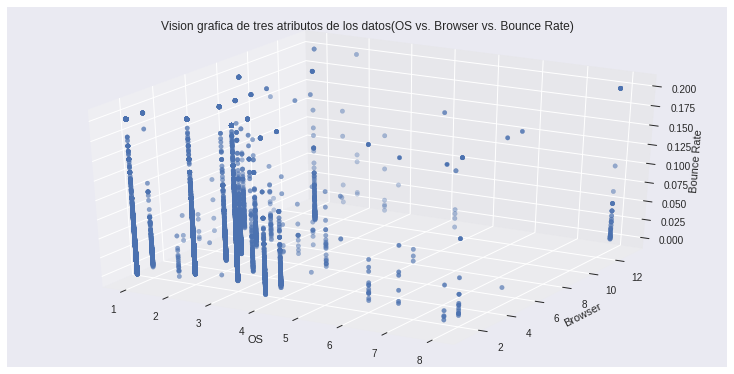

In [2]:
np.random.seed(31) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

#Cargamos los datos
data_file_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv'

#Mezclamos   
D = np.array(pd.read_csv(data_file_url, header=0))
Dx = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]


# Mapear valores de texto a numeros. Columna 10 (month). Jan=1, Feb=2,...
for month,num in zip(['Jan', 'Feb', 'Mar' , 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],range(12)):
    Dx[Dx[:,10]==month,10]=num

# Mapear valores de texto a numeros. Columna 15 (Vistor_type). New_Visitor=1, Returning_Visitor=2,Other=3
Dx[Dx[:,15]=='New_Visitor',15]=1
Dx[Dx[:,15]=='Returning_Visitor',15]=2
Dx[Dx[:,15]=='Other',15]=3


# Mapear valores de texto a numeros. Columna 16 (wekend). 
for valor,num in zip([False, True],range(2)):
    Dx[Dx[:,16]==valor,16]=num

# Mapear valores de texto a numeros. Columna 17 (revenuw). 
for valor,num in zip([False, True],range(2)):
    Dx[Dx[:,17]==valor,17]=num
        
# Asgurandonos de usar float64
Dx=Dx.astype('float64')

#Mostrar graficamente los datos (solo 3 atributos)
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:, 11], Dx[:, 12], Dx[:, 7])
ax.set_xlabel("OS")
ax.set_ylabel("Browser")
ax.set_zlabel("Bounce Rate")
ax.set_title("Vision grafica de tres atributos de los datos(OS vs. Browser vs. Bounce Rate)")

print('El dataset cargado tiene',Dx.shape[0],'instancias y ', Dx.shape[1], ' atributos')

## 3.1 Aplicamos el Algoritmo seleccinado: EM


El algoritmo EM tiene un único parámetro: el número de clústeres (K). 

Una vez fijado este valor, el primer paso consiste en inicializar el modelo.

- Se eligen unos centros iniciales de manera aleatoria
- Unas matrices de covarianzas fijas 
- Pesos iniciales para las diferentes componentes.  (Sin más información, lo más normal sería asignar a todas las componentes el mismo peso.)


In [0]:
######################## INICIALIZACION ########################
# Elegimos un número de clústeres a buscar
K = 4


# Asignar unas matrices de covarianzas iniciales
sigmas = []
for k in np.arange(K):
    sigmas.append( np.diag( 0.1 * np.ones( Dx.shape[1] ) ) )

x, y = np.mgrid[(np.min(Dx[:,0])-0.1):(np.max(Dx[:,0])+0.1):.01, 
                (np.min(Dx[:,1])-0.1):(np.max(Dx[:,1])+0.1):.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

# Inicialmente consideramos que todas las componentes tienen la misma probabilidad
PIs = np.ones(K)/K




def random_sample_float(n, mi, ma):
    return (ma - mi) * np.random.random_sample(n) + mi

# Elegir unos centros (uno para cada componente) de manera aleatoria
cDx = np.zeros(K*Dx.shape[1])
cDx.shape = (K,Dx.shape[1])

for d in np.arange(Dx.shape[1]):
    cDx[:,d] = random_sample_float(K, np.min(Dx[:,d]), np.max(Dx[:,d]))

print('Los centros iniciales elegidos aleatoriamente son:')
print(cDx)


# Ver asignaciones finales
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:, 0], Dx[:, 1], Dx[:, 3], c=Dy)
ax.scatter(cDx[:, 0], cDx[:, 1], cDx[:, 3], marker='*', c='#050505', s=1000)
ax.set_xlabel("Area")
ax.set_ylabel("Perimeter")
ax.set_zlabel("Length of kernel")
ax.set_title("Vision grafica los centroides iniciales (Area vs. Perimetro vs. Longitud)")
print("Hemos querido incluir la representacion grafica de los datos. Aunque los datos tienen 7 atributos, representamos solo 3 de ellos:")
print()







Una vez inicializado, el algoritmo EM ejecuta un bucle donde se repiten los pasos E y M hasta que se alcanza la convergencia. 

En el paso E se (re)calcula la probabilidad de que cada ejemplo pertenezca a cada una de las componentes (los valores $z_{ik}$). 

En el paso M se (re)calculan los parámetros del modelo: los centros de las distribuciones normales (uno por componente, $\mu_k$), las matrices de covarianzas de las normales (una por componente, $\Sigma_k$) y los coeficientes de importancia de las diferentes componentes ($\{\pi_k\}_{k=1}^K$, con $\sum_k \pi_k=1$).

El algoritmo alcanza la convergencia cuando los parámetros no cambian entre dos iteraciones consecutivas.


In [0]:
# Preparamos el vector donde guardamos la asignación probabilística 
# de cada elemento a un clúster (z_ik)
Dy_probs = np.zeros((Dx.shape[0], K))

# Flag de convergencia
iterando = True
# Dibujar los plots intermedios?
dibujar = False
# Si dibujas, sólo uno de cada 'frec_dibujo'
frec_dibujo = 10

it = 0

while iterando:

    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    
    # PASO E:
    # Calcular la asignacion a las componentes (z_ik)
    for k in np.arange(K):
        Dy_probs[:,k] = PIs[k] * multivariate_normal.pdf(Dx, mean=cDx[k,:], cov=sigmas[k])
    Dy_probs = Dy_probs/np.sum(Dy_probs,axis=1)[:,None]
    
    # PASO M:
    # - a: Calcular los nuevos centros de las K componentes
    for k in range(K):
        cDx[k,:] = np.sum(Dy_probs[:,k,None]*Dx,axis=0)/np.sum(Dy_probs[:,k])

    # - b: Calcular la matriz de covarianza (sigma) de las K componentes
    for k in range(K):
        sigmas[k] = np.sum([Dy_probs[i,k]* np.dot(Dx[i,:,None]-cDx[k,:,None],
                                                  (Dx[i,:,None]-cDx[k,:,None]).transpose())
                            for i in np.arange(Dx.shape[0])], axis=0) / np.sum(Dy_probs[:,k])

    # - c: Calcular los coeficientes de importancia de las diferentes componentes
    PIs = np.sum(Dy_probs,axis=0)/Dx.shape[0]

    if dibujar and (it % frec_dibujo) == 0:
        # Dibujar el plot con el resultado actual
        fig, ax = plt.subplots(figsize=(10,5))
        for k in np.arange(K):
            rv = multivariate_normal(mean=cDx[k,:], cov=sigmas[k])
            ax.contour(x, y, rv.pdf(pos), levels=10, linewidths=1,colors='k',alpha=0.1)
            ax.contourf(x, y, rv.pdf(pos), levels=10, cmap="RdBu_r",alpha=0.1)
        ax.scatter(Dx[:,0],Dx[:,1])
        ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='g')

    it += 1
    if np.allclose(cDx, cDx_ant):
        break
            


El resultado final del algoritmo es una matriz de probabilidades que asigna cada elemento a un clúster (componente) con cierta probabilidad. Si quisiésemos obtener una asignación determinista de cada caso a un único clúster, tomaríamos la componente que mayor probabilidad asigna a cada caso como su clúster:


Hemos querido incluir la representacion grafica de los datos. Aunque los datos tienen 7 atributos, representamos solo 3 de ellos:



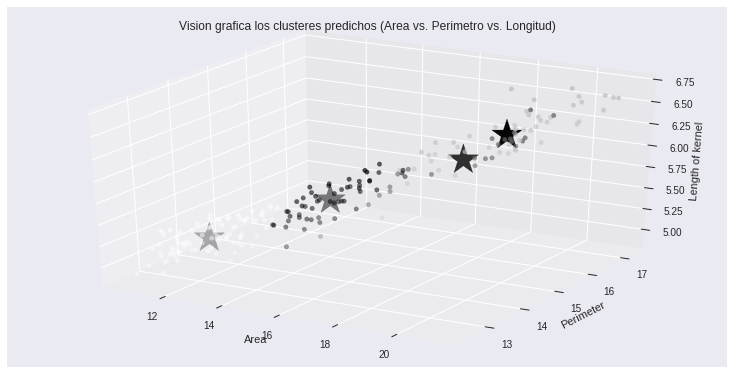

In [0]:
Dyp = np.argmax(Dy_probs,axis=1)


# Ver asignaciones finales
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:, 0], Dx[:, 1], Dx[:, 3], c=Dyp)
ax.scatter(cDx[:, 0], cDx[:, 1], cDx[:, 3], marker='*', c='#050505', s=1000)
ax.set_xlabel("Area")
ax.set_ylabel("Perimeter")
ax.set_zlabel("Length of kernel")
ax.set_title("Vision grafica los clusteres predichos (Area vs. Perimetro vs. Longitud)")
print("Hemos querido incluir la representacion grafica de los datos. Aunque los datos tienen 7 atributos, representamos solo 3 de ellos:")
print()


## 3.2 Evaluacion Intrinseca del Algoritmo seleccinado: K-means ++

- RMSSTD 
- R cuadrado
- Calinski-Harabasz
- Medida I
- Davies-Bouldin 

In [0]:
def medida_RMSSTD(X, Xyp, cXs):
    labels = np.unique(Xyp)
    labels=labels.astype('int')
    num = np.sum([ np.sum(np.sum(X[Xyp==labels[k],:]-cXs[labels[k],:],1)**2) for k in np.arange(labels.size)])
    den = X.shape[1] * np.sum([np.sum(Xyp==labels[k])-1 for k in np.arange(labels.size)])
    return np.sqrt(num/den)
  
def medida_R_cuadrado(X, Xyp, cXs):
    cXglob = np.mean(X,axis=0) 
    labels = np.sort(np.unique(Xyp)).astype('int')
    sumTotal = np.sum(np.sum(X-cXglob,1)**2) 
    interior = np.sum([ np.sum(np.sum(X[Xyp==labels[k],:]-cXs[labels[k],:],1)**2) for k in np.arange(labels.size)])
    return interior/sumTotal 

def distancia_euclidiana(x, y):   
    return np.sqrt(np.sum((x - y) ** 2))

def matriz_distancias(X, distancia):
    mD = np.zeros((X.shape[0],X.shape[0]))
    for pair in it.product(np.arange(X.shape[0]), repeat=2):
        mD[pair] = distancia(X[pair[0],:],X[pair[1],:])
    return mD

def calcular_matriz_a(X, Xyp, mD):
    labels = np.sort(np.unique(Xyp))
    factores = 1.0/(np.array([np.sum(Xyp==labels[k]) for k in np.arange(labels.size)])-1)
    aX = np.zeros(X.shape[0])
    for i in np.arange(X.shape[0]):
        k = Xyp[i]
        aX[i] = factores[k] * np.sum([mD[i,ip] 
                                      for ip in np.arange(X.shape[0])[Xyp==labels[k]]])
    return(aX)

def calcular_matriz_b(X, Xyp, mD):
    labels = np.sort(np.unique(Xyp))
    factores = 1.0/np.array([np.sum(Xyp==labels[k]) for k in np.arange(labels.size)])
    bX = np.zeros(X.shape[0])
    for i in np.arange(X.shape[0]):
        k = Xyp[i]
        ran = np.arange(labels.size)
        ran = ran[np.arange(labels.size)!=k]
        res = np.array([factores[h] * np.sum([mD[i,ip]
                                              for ip in np.arange(X.shape[0])[Xyp==labels[h]]])
                        for h in ran])
        bX[i] = np.min(res)
    return(bX)

def medida_silueta(X, Xyp, distancia):
    mD = matriz_distancias(X, distancia)
    A = calcular_matriz_a(X, Xyp, mD)
    B = calcular_matriz_b(X, Xyp, mD)
    impl = (B-A)/np.maximum(A,B)
    return np.mean(impl)


def medida_calinski_harabasz(X, Xyp, cXs, distancia):
    cXglob = np.mean(X,axis=0) 
    labels = np.sort(np.unique(Xyp))
    factores = np.array([np.sum(Xyp==labels[k]) for k in np.arange(labels.size)])
    num = (X.shape[0]-labels.size)*np.sum([factores[k]*distancia(cXs[k,:],cXglob)**2 
                                           for k in np.arange(cXs.shape[0])])
    den = (labels.size-1)*np.sum([np.sum([distancia(X[i,:],cXs[k,:])**2 
                                            for i in np.arange(X.shape[0])[Xyp==labels[k]]])
                                           for k in np.arange(cXs.shape[0])])
    return num/den


def medida_I(X, Xyp, cXs, distancia):
    cXglob = np.mean(X, axis = 0) 
    labels = np.sort(np.unique(Xyp))
    maxDcs = np.max(matriz_distancias(cXs, distancia))
    num = np.sum([distancia(X[i,:], cXglob) for i in np.arange(X.shape[0])])
    den = labels.size * np.sum([np.sum([distancia(X[i,:], cXs[k,:])
                                        for i in np.arange(X.shape[0])[Xyp==labels[k]]])
                                for k in np.arange(cXs.shape[0])])
    return (num*maxDcs/den)**2


def medida_davies_bouldin(X, Xyp, cXs, distancia):
    labels = np.sort(np.unique(Xyp))
    mDcs = matriz_distancias(cXs, distancia)
    np.fill_diagonal(mDcs, np.Infinity)
    vals = np.array([1.0 / np.sum(Xyp==labels[k]) * np.sum([distancia(X[i,:], cXs[k,:])
                                                            for i in np.arange(X.shape[0])[Xyp==labels[k]]])
                     for k in np.arange(cXs.shape[0])])
    res = 1.0/labels.size*np.sum([np.max([(vals[k]+vals[kp])/mDcs[k,kp] 
                                          for kp in np.arange(labels.size)])
                                  for k in np.arange(labels.size)])
    return res

cDx= np.squeeze(np.asarray(cDx))
print('El error RMSSTD es = ',medida_RMSSTD(Dx, Dyp, cDx))
print('El valor de la medida R cuadrado es = ', medida_R_cuadrado(Dx, Dyp, cDx))
#print('El valor de la medida Silueta es = ', medida_silueta(Dx, Dyp, distancia_euclidiana))
print('El valor de la medida Calinski-Harabasz es = ', medida_calinski_harabasz(Dx, Dyp, cDx, distancia_euclidiana))
print('El valor de la medida I es = ', medida_I(Dx, Dyp, cDx, distancia_euclidiana))
print('El valor de la medida Davies-Bouldin es = ', medida_davies_bouldin(Dx, Dyp, cDx, distancia_euclidiana))




El error RMSSTD es =  339.01802042476885
El valor de la medida R cuadrado es =  0.4784712256473076
El valor de la medida Calinski-Harabasz es =  13878.563110792975
El valor de la medida I es =  14431718.155312682
El valor de la medida Davies-Bouldin es =  0.5559562262614335


## 3.3 Analisis de la evlauciaon del Algoritmo seleccinado: K-means ++


### ANALISIS AQUI